<a href="https://colab.research.google.com/github/Aryabhatt-O/Text-Processing/blob/main/Text_processing(now_bengali_5_cluster).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

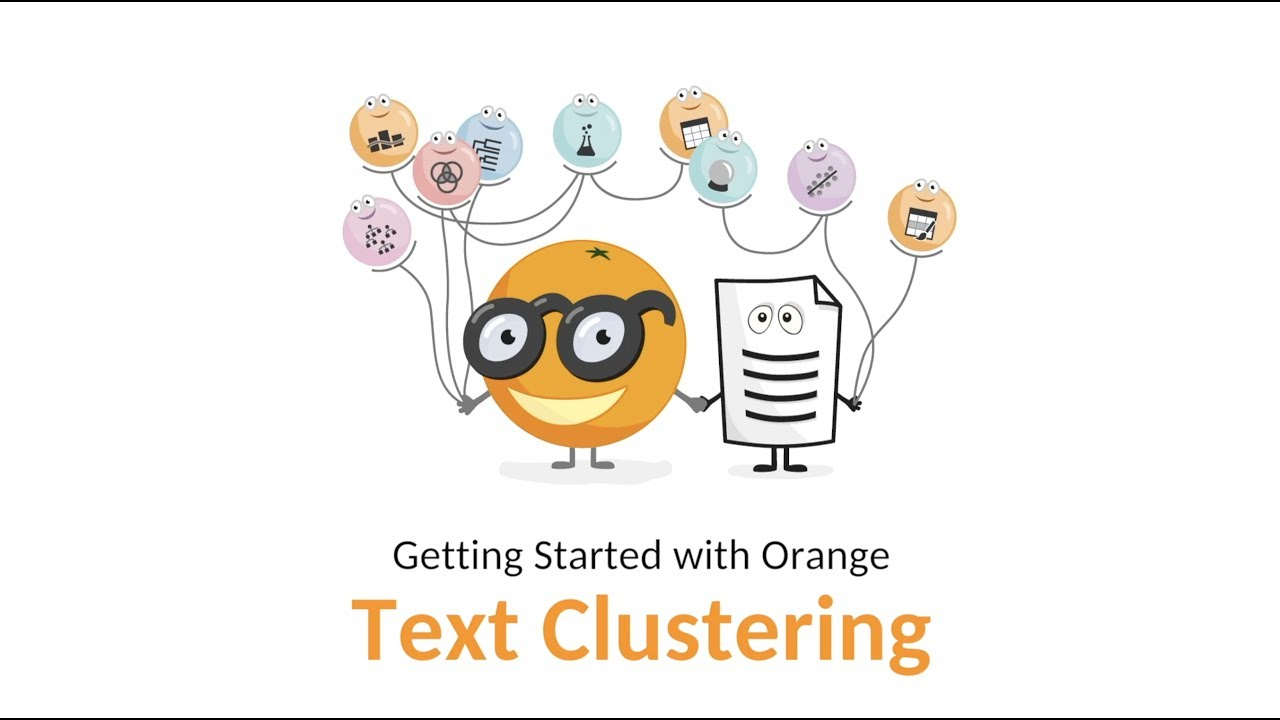
---
© **AMARTYA**




# **Importing Data** ⚡

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io
import pandas as pd

data = pd.read_csv(io.StringIO(uploaded['BengaliTextcheckData.csv'].decode("utf-16")))

# **Data Processing** ✌

### *Step 1*





In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
df = data['slno,Class,text']


### *Step 2*

In [ ]:
text = df.str.split(',',n = 3, expand = True)
text

### *Step 3*

In [ ]:
data['Doc_no'] = text[0]
data['Class'] = text[1]
data['Text'] = text[2]


### *Step 4*

In [ ]:
data.drop('slno,Class,text', axis=1, inplace=True)

### *Step 5*

In [ ]:
import nltk
nltk.download('stopwords')

### *Step 6*

In [ ]:
# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('bengali')
data['Text_without_stopwords'] = data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


### *Step 7*

In [ ]:
data.drop(columns = 'Text',inplace = True)


### *Step 8*(Stemmer 1)

In [ ]:
!pip install bnltk 
from bnltk.stemmer import BanglaStemmer  
bn_stemmer = BanglaStemmer()  

### *Step 9*(Stemmer2 ,fast)

In [ ]:
# !pip install bangla-stemmer
# from bangla_stemmer.stemmer.stemmer import BanglaStemmer
# # word = 'কবিরগুলিকে'
# stm = BanglaStemmer()

### *Step 10*

In [ ]:
data['Text_stemmed'] = data['Text_without_stopwords'].apply(lambda x: [bn_stemmer.stem(x)]) 
data['Text_stemmed']=[" ".join(review) for review in data['Text_stemmed'].values]
data['Text_stemmed_without_no'] = data['Text_stemmed'].str.replace('\d+', '')


### *Step 11*

In [ ]:
from sklearn.preprocessing import LabelEncoder
X = data
Y_target = data['Class']
from sklearn.preprocessing import LabelEncoder
leb = LabelEncoder()
Y_target = leb.fit_transform(Y_target)
a = dict(zip(leb.classes_,range(len(leb.classes_))))
print('Total class''-->',data['Class'].nunique(), "\n","\n", data['Class'].value_counts())


### *Step 12*(tf-idf)

In [ ]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(data['Text_stemmed_without_no'])
df_tfidf = pd.DataFrame(x.toarray(), columns=tfidf.get_feature_names())



# **Modelling** 💻

### **Spectral Kmeans**

In [ ]:
from sklearn.cluster import SpectralClustering
spectral_model_rbf = SpectralClustering(n_clusters = 5, affinity ='nearest_neighbors',n_neighbors = 9) 
labels_rbf = spectral_model_rbf.fit_predict(df_tfidf)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn.metrics as sm
%matplotlib inline

In [ ]:
import sklearn.metrics as metrics
from scipy.optimize import linear_sum_assignment as linear_assignment
def cluster_acc(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    _make_cost_m = lambda x:-x + np.max(x)
    indexes = linear_assignment(_make_cost_m(cm))
    indexes = np.concatenate([indexes[0][:,np.newaxis],indexes[1][:,np.newaxis]], axis=-1)
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    acc = np.trace(cm2) / np.sum(cm2)
    return acc

### **Kmeans/Kmeans++** 

In [ ]:
kmeans = KMeans(n_clusters=5,init='k-means++')
kmeans.fit(df_tfidf)

In [ ]:
import numpy as np
from scipy import spatial
from scipy.spatial import KDTree
from scipy.spatial import cKDTree
import numpy as np
import random
from random import *
import heapq
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
# !pip install sklearn
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import AgglomerativeClustering
from collections import Counter, defaultdict
import pandas as pd
# import numpy as np
import seaborn as sns
import operator
# from sklearn import datasets
from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import sklearn.metrics as sm
%matplotlib inline


# **Cluster Information** 📂

### *Step 1*

In [ ]:
cluster_info = {i: Y_target[np.where(kmeans.labels_ == i)] for i in range(kmeans.n_clusters)}
# cluster_info = {i: Y_target[np.where(labels_rbf == i)] for i in range(5)}


### *Step 2*(***Nested Dictionary***)
### `{Cluster : {Class : Counts}}`)

In [ ]:
from itertools import groupby
def get_unique(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

d={i:dict(zip(sorted(get_unique(cluster_info[i])),sum([(list(group)) for key, group in groupby(np.delete(np.bincount(cluster_info[i]), np.where(np.bincount(cluster_info[i]) == 0)))],[]))) for i in cluster_info}
d

# **DataFrame Creation** ✍

### Step 1

In [ ]:
df = pd.DataFrame.from_dict({(i,j): d[i][j] for i in d.keys() for j in d[i].keys()},orient='index')
df.index = pd.MultiIndex.from_tuples(df.index)
df.index = pd.MultiIndex.from_tuples(df.index)
new_df = df.reset_index()
new_df.rename({'level_0': 'Cluster', 'level_1': 'Class', 0: 'Value'}, axis=1, inplace=True)
new_df.head(20)

### Step 2

In [ ]:
import math
e_df = new_df
e_df["Cluster_Sum"] = e_df.groupby("Cluster")["Value"].transform("sum")
e_df['Precision'] = e_df['Value']/e_df['Cluster_Sum']
e_df['Class_Sum'] = e_df.groupby('Class')['Value'].transform('sum')
e_df['Recall'] = e_df['Value']/e_df['Class_Sum']
e_df['F_measure'] = 2*(e_df['Precision'] * e_df['Recall'])/(e_df['Precision'] + e_df['Recall'])
e_df['Clus_to_Class'] = e_df.loc[e_df.groupby('Cluster')['F_measure'].transform('idxmax'), 'Class'].values
e_df['Entropy'] = (e_df['Precision'])*np.log10(e_df['Precision']).abs()
e_df['Entropy_sum_cluster_wise'] = e_df.groupby('Cluster')['Entropy'].transform('sum')
Cluster_total = dict(zip(e_df.Cluster, e_df.Cluster_Sum))
total = sum(Cluster_total.values())
e_df['Weight_cluster_wise'] = e_df.groupby('Cluster')['Value'].transform('sum')/total
e_df['Weighted_Entropy_cluster_wise'] = e_df['Weight_cluster_wise'] * e_df['Entropy_sum_cluster_wise']

In [ ]:
e_df.head(50)

### Step 3( **Entropy information**) 
### `{Cluster : Entropy value}`
### `total_entropy  = ∑ Entropy value` 

In [ ]:
Entropy_info = dict(zip(e_df.Cluster, e_df.Weighted_Entropy_cluster_wise))
total_entropy = sum(Entropy_info.values())
# Entropy_info
total_entropy

# **Cluster to Class Mapping** 🧭
## `{Cluster : Class}`

In [ ]:
Clust_to_Class_dict = dict(zip(e_df.Cluster, e_df.Clus_to_Class))

In [ ]:
Clust_to_Class_dict

# **Model predicted Level** ⏩

In [ ]:
an = kmeans.labels_
# an = labels_rbf
an

# **Actual Label Interpretation** ❎

In [ ]:
actual_level = np.vectorize(Clust_to_Class_dict.get)(an)
actual_level

# **Metric Report** ⛅

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_target,actual_level))

# **Accuracy Measurement** 💯

### `Accuracy Function` using [Hungarian algorithm](https://www.wikiwand.com/en/Hungarian_algorithm)





In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn.metrics as sm
%matplotlib inline
from sklearn import metrics
from scipy.optimize import linear_sum_assignment as linear_assignment
def cluster_acc(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    _make_cost_m = lambda x:-x + np.max(x)
    indexes = linear_assignment(_make_cost_m(cm))
    indexes = np.concatenate([indexes[0][:,np.newaxis],indexes[1][:,np.newaxis]], axis=-1)
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    acc = np.trace(cm2) / np.sum(cm2)
    return acc
accuracy = cluster_acc(Y_target,actual_level)
print(accuracy)

### `Clustering performance evaluation` using [scikit learn](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)



### `Extrinsic Methods`

In [ ]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import v_measure_score
h_score = homogeneity_score(Y_target,actual_level)
v_score = v_measure_score(Y_target,actual_level)
c_score  = completeness_score(Y_target,actual_level)
print('homogeneity score ---->',h_score,"\n",'v_measure_score ---->',v_score,"\n",'completeness_score ---->',c_score)

### `Intrinsic Method`



```
The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering.Higher the score higher the Accuracy
```






In [ ]:
from sklearn.metrics import silhouette_score
print(f'Silhouette Score(n=5): {silhouette_score(df_tfidf, actual_level)}')


# `For Understanding`

In [ ]:
Y_target

In [ ]:
actual_level

In [ ]:
labels_rbf

In [ ]:
Clust_to_Class_dict

# **END** 🔚

### Class:[Cluster i, Cluster j....]

In [ ]:


flipped = {}

for key, value in Clust_to_Class_dict.items():
    if value not in flipped:
        flipped[value] = [key]
    else:
        flipped[value].append(key)

flipped

## **Manual Checking**

In [ ]:
freq = []
for i in flipped.keys():
  if len(flipped[i]) > 1:
    freq.append(flipped[i])
flat_freq  = sum(freq, [])
flat_freq    
# cluster number

In [ ]:
# e_df.loc[e_df['Cluster'] == 15]

df_checker = e_df.loc[e_df['Cluster'].isin(flat_freq)]
df_checker1 = df_checker[~df_checker['Class'].isin(flipped.keys())]

df_checker1

In [ ]:
Clust_to_Class_dict_prime = dict(zip(df_checker1.Cluster, df_checker1.Class))
Clust_to_Class_dict_prime

In [ ]:
Clust_to_Class_dict.update(Clust_to_Class_dict_prime)
Clust_to_Class_dict

In [ ]:
flipped_prime = {}

for key, value in Clust_to_Class_dict.items():
    if value not in flipped_prime:
        flipped_prime[value] = [key]
    else:
        flipped_prime[value].append(key)

flipped_prime

In [ ]:
flipped_prime = {}

for key, value in Clust_to_Class_dict_prime.items():
    if value not in flipped_prime:
        flipped_prime[value] = [key]
    else:
        flipped_prime[value].append(key)

flipped_prime

In [ ]:
freq = []
for i in flipped_prime.keys():
  if len(flipped_prime[i]) > 1:
    freq.append(flipped_prime[i])
flat_freq  = sum(freq, [])
flat_freq

In [ ]:
df_checker = e_df.loc[e_df['Cluster'].isin(flat_freq)]
df_checker1 = df_checker[~df_checker['Class'].isin(list(flipped_prime.keys()) + list(flipped.keys()))]

df_checker1

In [ ]:
Clust_to_Class_dict_prime_prime = dict(zip(df_checker1.Cluster, df_checker1.Class))
Clust_to_Class_dict_prime_prime

In [ ]:
flipped_prime_prime = {}

for key, value in Clust_to_Class_dict_prime_prime.items():
    if value not in flipped_prime_prime:
        flipped_prime_prime[value] = [key]
    else:
        flipped_prime_prime[value].append(key)

flipped_prime_prime

In [ ]:
freq = []
for i in flipped_prime_prime.keys():
  if len(flipped_prime_prime[i]) > 1:
    freq.append(flipped_prime_prime[i])
flat_freq  = sum(freq, [])
flat_freq

In [ ]:
df_checker = e_df.loc[e_df['Cluster'].isin(flat_freq)]
df_checker1 = df_checker[~df_checker['Class'].isin(list(flipped_prime_prime.keys())+list(flipped_prime.keys()) + list(flipped.keys()))]

df_checker1

In [ ]:
from operator import itemgetter

my_dict = {x: x**2 for x in range(10)}

my_dict
# itemgetter(1, 3, 2, 5)(my_dict)

In [ ]:
from collections import Counter, defaultdict
d = (Counter(kmeans.labels_))
d

In [ ]:
df = pd.DataFrame.from_dict(d, orient="index").reset_index()
df.columns = ['Cluster_i', 'Number of points']
df_sorted = df.sort_values('Cluster_i')
df_sorted.index.names = ['Class']


In [ ]:
df_sorted

In [ ]:

# df_sorted.drop(columns = 'sum',inplace = True)
df_sorted['total'] = df_sorted['Number of points'].sum()   



In [ ]:
df_sorted


In [ ]:
from sklearn.metrics.cluster import rand_score
rand_score(Y_target,kmeans.labels_)

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(Y_target,kmeans.labels_)

In [ ]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
adjusted_mutual_info_score(Y_target,kmeans.labels_)

In [ ]:
from sklearn.cluster import SpectralClustering
import numpy as np
# clustering = SpectralClustering(n_clusters=3,
#                                 affinity ='rbf',
#         random_state=0).fit(df_tfidf)
# clustering.labels_


In [ ]:
spectral_model_rbf = SpectralClustering(n_clusters = 38, affinity ='nearest_neighbors',n_neighbors = 9) 
  
# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(df_tfidf)

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(Y_target,labels_rbf)

In [ ]:
from sklearn.metrics.cluster import rand_score
rand_score(Y_target,labels_rbf)


In [ ]:
# kmeans = KMeans(init = 'k-means++',n_clusters= 38)
# kmeans.fit(proj_df)
# kmeans.labels_
accuracy = cluster_acc(Y_target,labels_rbf)
print(accuracy)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df_tfidf, nn=8)

# Plot the graph Laplacian as heat map.
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(graph_laplacian, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian');

In [ ]:
graph_laplacian

In [ ]:
from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)

In [ ]:
import numpy as np
np.unique(np.imag(eigenvals))

In [ ]:
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

In [ ]:
eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=2), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

In [ ]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

In [ ]:
eigenvals_sorted

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$')

In [ ]:
def plotValues(s):
    fig=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
    plt.scatter(np.arange(s.shape[0]), s, 20, c="b", alpha=1, marker=r'o')
    plt.xlabel('Rank of eigenvalue')
    plt.ylabel('eigenvalue')
    plt.show()

In [ ]:
plotValues(eigenvals)

In [ ]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

index_lim = 10

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$')

In [ ]:
# zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e10)
# len(eigenvals[zero_eigenvals_index])

In [ ]:
idx = np.argpartition(eigenvals, 38)
print((idx[1:39]))

In [ ]:
zero_eigenvals_index= idx[1:39]
zero_eigenvals_index


In [ ]:
# import heapq
# print(heapq.nsmallest(38,eigenvals))

In [ ]:
proj_df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index.squeeze()])
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
proj_df

In [ ]:
def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corresponding to the first 
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn.metrics as sm
%matplotlib inline

In [ ]:
kmeans = KMeans(init = 'k-means++',n_clusters= 32)
kmeans.fit(proj_df)
# kmeans.labels_
accuracy = cluster_acc(Y_target,kmeans.labels_)
print(accuracy)
# kmeans.cluster_centers_

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(Y_target,kmeans.labels_)

In [ ]:
from sklearn.metrics.cluster import rand_score
rand_score(Y_target,kmeans.labels_)


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(Y_target,kmeans.labels_, average='weighted')

In [ ]:
Y_target

In [ ]:
import sklearn.metrics as metrics
from scipy.optimize import linear_sum_assignment as linear_assignment
def cluster_acc(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    _make_cost_m = lambda x:-x + np.max(x)
    indexes = linear_assignment(_make_cost_m(cm))
    indexes = np.concatenate([indexes[0][:,np.newaxis],indexes[1][:,np.newaxis]], axis=-1)
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    acc = np.trace(cm2) / np.sum(cm2)
    return acc
accuracy = cluster_acc(Y_target,kmeans.labels_)

In [ ]:
def findDistance(point1, point2):
    
    eucDis = 0
    for i in range(len(point1)):
        eucDis = eucDis + (point1[i] - point2[i])**2
 
    return eucDis**0.5 


def calcDunnIndex(points, cluster):

    # points -- all data points
    # cluster -- cluster centroids

    
    numer = float('inf')
    for c in cluster: # for each cluster
        for t in cluster: # for each cluster
           # print(t, c)
            if (t == c).all(): continue # if same cluster, ignore
            ndis = findDistance(t, c)
           # print('Numerator', numerator, ndis)
            numer = min(numer, ndis) # find distance between centroids
            
    denom = 0
    for c in cluster: # for each cluster
        for p in points: # for each point
            for t in points: # for each point
                if (t == p).all(): continue # if same point, ignore
                ddis = findDistance(t, p)
            #    print('Denominator', denominator, ddis)
                denom = max(denom, ddis)
                
    return (numer/denom) 


In [ ]:
accuracy = cluster_acc(Y_target,kmeans.labels_)
print(accuracy)

In [ ]:
df_tfidf_transposed = df_tfidf.T


In [ ]:
df_tfidf_transposed

In [ ]:
A = df_tfidf_transposed

In [ ]:
A

In [ ]:
import numpy as np
u, s, v = np.linalg.svd(A, full_matrices=True)

In [ ]:
u_df = pd.DataFrame(u)
u_df

In [ ]:
u_df_200 = u_df.T.head(200).T


In [ ]:
u_df_200

In [ ]:
A.T

In [ ]:
# A_vector = A^T * u_df_100
# k = A.T.mul(u_df_100)

import numpy as np
  

res = np.dot(A.T,u_df_200)


In [ ]:
A_vector = pd.DataFrame(res)
A_vector

In [ ]:
print('Total class''-->',data['Class'].nunique(), "\n","\n", data['Class'].value_counts())

In [ ]:


from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
true_k = 38
model = KMeans(n_clusters=true_k)
model.fit(A.T)


print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")

# Y = vectorizer.transform(["chrome browser to open."])
# prediction = model.predict(Y)
# print(prediction)

# Y = vectorizer.transform(["My cat is hungry."])
# prediction = model.predict(Y)
# print(prediction)
 

In [ ]:
predict = model.fit_predict(A.T)

In [ ]:
from sklearn.decomposition import PCA
# from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

In [ ]:
Y_target

In [ ]:
labels

In [ ]:
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
n_clusters = 38
from sklearn.metrics import silhouette_samples, silhouette_score
cluster_labels = model.fit_predict(A_vector)
silhouette_avg = silhouette_score(A_vector, cluster_labels)
print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(A_vector, cluster_labels)

In [ ]:
labels

In [ ]:
data['Doc_no']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import pandas as pd
# set of documents
# train = ['The sky is blue.','The sun is bright.']
# test = ['The sun in the sky is bright', 'We can see the shining sun, the bright sun.']
# instantiate the vectorizer object
# countvectorizer = CountVectorizer(analyzer= 'word', stop_words='english')
tfidfvectorizer = TfidfVectorizer(analyzer='word')
# convert th documents into a matrix
# count_wm = countvectorizer.fit_transform(train)
tfidf_wm = tfidfvectorizer.fit_transform(data['Text'])
#retrieve the terms found in the corpora
# if we take same parameters on both Classes(CountVectorizer and TfidfVectorizer) , it will give same output of get_feature_names() methods)
#count_tokens = tfidfvectorizer.get_feature_names() # no difference
# count_tokens = countvectorizer.get_feature_names()
tfidf_tokens = tfidfvectorizer.get_feature_names()
# df_countvect = pd.DataFrame(data = count_wm.toarray(),index = ['Doc1','Doc2'],columns = count_tokens)
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)
# print("Count Vectorizer\n")
# print(df_countvect)
print("\nTD-IDF Vectorizer\n")
print(df_tfidfvect)

In [ ]:
from nltk.tokenize import RegexpTokenizer 
tokenizer  = word_tokenize = RegexpTokenizer("[\u0980-\u09FF']+")

In [ ]:
data['Text'] = data['Text'].apply(lambda x:tokenizer.tokenize(x))

In [ ]:
import nltk
from nltk.corpus import stopwords
print(stopwords.fileids())

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import pandas as pd
# set of documents
# train = ['The sky is blue.','The sun is bright.']
# test = ['The sun in the sky is bright', 'We can see the shining sun, the bright sun.']
# instantiate the vectorizer object
# countvectorizer = CountVectorizer(analyzer= 'word', stop_words='english')
tfidfvectorizer = TfidfVectorizer(analyzer='word')
# convert th documents into a matrix
# count_wm = countvectorizer.fit_transform(train)
tfidf_wm = tfidfvectorizer.fit_transform(data['Text'])
#retrieve the terms found in the corpora
# if we take same parameters on both Classes(CountVectorizer and TfidfVectorizer) , it will give same output of get_feature_names() methods)
#count_tokens = tfidfvectorizer.get_feature_names() # no difference
# count_tokens = countvectorizer.get_feature_names()
tfidf_tokens = tfidfvectorizer.get_feature_names()
# df_countvect = pd.DataFrame(data = count_wm.toarray(),index = ['Doc1','Doc2'],columns = count_tokens)
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = 'Doc_no',columns = tfidf_tokens)
# print("Count Vectorizer\n")
# print(df_countvect)
print("\nTD-IDF Vectorizer\n")
print(df_tfidfvect)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(data['Text_stemmed'])

In [ ]:
a= x.toarray()  
v.get_feature_names_out()

In [ ]:
score = dict(zip(v.get_feature_names(), x.toarray()[0]))

In [ ]:
keywords = sorted(score, key=score.get, reverse=True)[:1000]
keywords

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# docs = ['why hello there', 'omg hello pony', 'she went there? omg']
vec = CountVectorizer()
X = vec.fit_transform(data['Text'])
df_ben = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(df_ben)

In [ ]:
import texthero as hero
# data = hero.remove_digits(data['Text'])
# # data = hero.remove_punctuation(data['Text'])
# # data = hero.remove_brackets(data['Text'])


In [ ]:
from nltk.tokenize import RegexpTokenizer 
tokenizer  = word_tokenize = RegexpTokenizer("[\u0980-\u09FF']+")

In [ ]:
data['Text'] = data['Text'].apply(lambda x:tokenizer.tokenize(x))


In [ ]:
data['Text']=[" ".join(i) for i in data['Text'].values]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(data['Text'])

In [ ]:
import texthero as hero
data['tfidf'] = hero.tfidf(data['Text'])

data

In [ ]:
import pandas as pd
pd.DataFrame(data['Doc_no'],data['tfidf'])

In [ ]:
from nltk.tokenize import RegexpTokenizer 
tokenizer  = word_tokenize = RegexpTokenizer("[\u0980-\u09FF']+")

In [ ]:
data['Text'] = data['Text'].apply(lambda x:tokenizer.tokenize(x))


In [ ]:
data

In [ ]:
df_pivot = data.pivot(index='Doc_no', columns='Text', values='tfidf')

In [ ]:
df_pivot

In [ ]:
!pip install bnlp_toolkit

In [ ]:
from bnlp import NLTKTokenizer

bnltk = NLTKTokenizer()
word_tokens = bnltk.word_tokenize(data['Text'][0])
# sentence_tokens = bnltk.sentence_tokenize(text)
print(word_tokens)

In [ ]:
!pip install texthero

In [ ]:
series = pd.Series(df)

In [ ]:
series

In [ ]:
import texthero as hero
hero.remove_stopwords(series)

In [ ]:
!pip install bnlp_toolkit

In [ ]:
from bnlp import NLTKTokenizer

bnltk = NLTKTokenizer()
word_tokens = bnltk.word_tokenize(series)
# sentence_tokens = bnltk.sentence_tokenize(text)
print(word_tokens)
# print(sentence_tokens)

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction import text
stopwordsSK = text.ENGLISH_STOP_WORDS

len(stopwordsSK)

In [ ]:
bowA = []
bowB = []  

word_tokens1 = word_tokenize(docA)
word_tokens2 = word_tokenize(docB)  



for w1 in word_tokens1:  
    if w1 not in stopwordsSK:  
        bowA.append(w1)  


for w2 in word_tokens2:  
    if w2 not in stopwordsSK:  
        bowB.append(w2)
print(bowA,bowB)

In [ ]:
wordSet = set(bowA).union(set(bowB))

In [ ]:
wordDictA = dict.fromkeys(wordSet, 0) 
wordDictB = dict.fromkeys(wordSet, 0)

In [ ]:
for word in bowA:
    wordDictA[word]+=1
    
for word in bowB:
    wordDictB[word]+=1

In [ ]:
import pandas as pd
pd.DataFrame([wordDictA, wordDictB])

In [ ]:
def computeTF(wordDict, bow):
    tfDict = {}
    bowCount = len(bow)
    for word, count in wordDict.items():
        tfDict[word] = count/float(bowCount)
    return tfDict

In [ ]:
tfBowA = computeTF(wordDictA, bowA)
tfBowB = computeTF(wordDictB, bowB)

In [ ]:
tfBowA

In [ ]:
tfBowB

In [ ]:
def computeIDF(docList):
    import math
    idfDict = {}
    N = len(docList)
    
    idfDict = dict.fromkeys(docList[0].keys(), 0)
    for doc in docList:
        for word, val in doc.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log10(0.5+N / float(val))
        
    return idfDict    

In [ ]:
idfs = computeIDF([wordDictA, wordDictB])

In [ ]:
idfs

In [ ]:
def computeTFIDF(tfBow, idfs):
    tfidf = {}
    for word, val in tfBow.items():
        tfidf[word] = val*idfs[word]
    return tfidf

In [ ]:
tfidfBowA = computeTFIDF(tfBowA, idfs)
tfidfBowB = computeTFIDF(tfBowB, idfs)

In [ ]:
import pandas as pd
pd.DataFrame([tfidfBowA, tfidfBowB])

In [ ]:
def intersection(first, *others):
    return set(first).intersection(*others)

intersection(bowA,bowB)